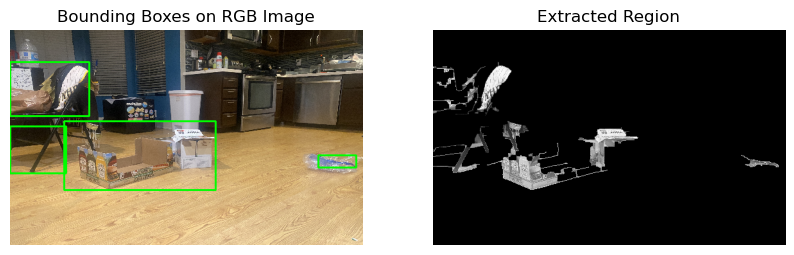

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

rgb_image = cv2.imread('IMG_9395.JPG') 
depth_image = cv2.imread('path_to_output_image.jpg', cv2.IMREAD_UNCHANGED)  
depth = cv2.resize(depth_image, (550, 336), interpolation=cv2.INTER_CUBIC)
rgb_image = cv2.resize(rgb_image, (550, 336), interpolation=cv2.INTER_CUBIC)
mask_depth = (depth > 12).astype(np.uint8)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
dilated_array = cv2.dilate(mask_depth, structuring_element)
mask_depth = cv2.morphologyEx(dilated_array, cv2.MORPH_CLOSE, structuring_element)

# Repeat mask to match RGB channels
mask_depth1 = np.repeat(mask_depth[:, :, np.newaxis], 3, axis=2)

# Blur and edge detection
blurred = cv2.GaussianBlur(rgb_image[:, :, 2], (5, 5), 0)
edges = cv2.Canny(blurred, threshold1=100, threshold2=150)

# Apply depth mask to edges
masked_edges = cv2.bitwise_and(edges, mask_depth)

masked_edges = cv2.morphologyEx(masked_edges, cv2.MORPH_CLOSE, np.ones((5, 5)))


contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area_threshold = 200
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area_threshold]

image_with_bounding_boxes = rgb_image.copy()
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(image_with_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Create mask and apply it to the red channel of the RGB image
mask = np.zeros_like(masked_edges)
cv2.drawContours(mask, filtered_contours, -1, 255, -1)
mask_3channel = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

new_image = cv2.bitwise_and(rgb_image[:, :, 2], mask)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Bounding Boxes on RGB Image')
plt.imshow(cv2.cvtColor(image_with_bounding_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Extracted Region')
plt.imshow(new_image, cmap='gray')
plt.axis('off')

plt.show()


In [30]:
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


def region_growing(depth_image, depth_threshold=3):
    visited = set()
    cols = len(depth_image[0])
    rows = len(depth_image)
    # 8-connected neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    mask = depth_image < 10
    filtered_image = depth_image.copy()
    segmented = np.zeros_like(depth_image)

    filtered_image[mask] = 0

    depth_image = filtered_image

    for row in range(rows):
        for col in range(cols):
            seed_point = (row, col)
            if seed_point not in visited:
                if depth_image[row,col] != 0:
                    visited.add(seed_point)
                    queue = deque([seed_point])
                    seed_color = depth_image[row, col]
                    seed_depth = depth_image[row, col]

                    while queue:
                        x, y = queue.popleft()
                        for dx, dy in neighbors:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited:
                                depth = depth_image[nx, ny]
                                depth_diff = abs(int(depth) - int(seed_depth))
                                if depth_diff < depth_threshold:
                                    seed_depth = depth
                                    queue.append((nx, ny))
                                    visited.add((nx, ny))
                                    segmented[nx, ny] = seed_color

    return segmented

In [31]:
rgb_image_path = 'IMG_9395.JPG' 
depth_image_path = 'path_to_output_image.jpg'
rgb_image = cv2.imread(rgb_image_path)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB) 

rgb_image = cv2.resize(rgb_image, (640, 640), interpolation=cv2.INTER_CUBIC)

depth_image = cv2.imread(depth_image_path, cv2.IMREAD_GRAYSCALE)  
depth_image = cv2.resize(depth_image, (640, 640), interpolation=cv2.INTER_CUBIC)
seed_points = [(0, 200), (200, 400), (350, 350), (400, 600)]

# Perform region growing
segmented_image = region_growing(depth_image, depth_threshold=1)

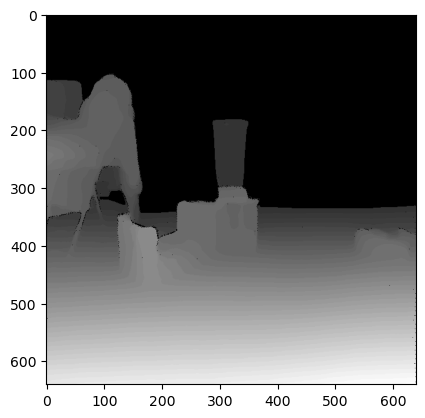

In [32]:
plt.imshow(segmented_image, cmap='gray')